#  K-Nearest Neighbour (KNN) exercise
Complete and hand in this completed worksheet (including its output and supporting code outside of the worksheet) with your assigment submission.For more details For more details see the assignments page on the course website.

The kNN classifier consists of two stages:
- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from cs231n.data_utils import load_CIFAR10

In [3]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [4]:
cifar10_dir = 'cs231n\\datasets'
try:
    del x_train, y_train
    del x_test, y_test
except:
    pass

In [6]:
x_train, y_train, x_test, y_test = load_CIFAR10(cifar10_dir)
print('Training data shape: ', x_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


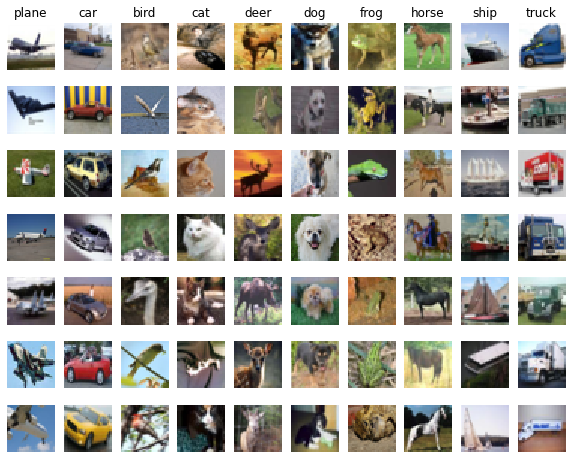

In [296]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train==y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [7]:
num_training = 1000
mask = list(range(num_training))
x_train = x_train[mask]
y_train = y_train[mask]
num_test = 100
mask = list(range(num_test))
x_test = x_test[mask]
y_test = y_test[mask]
x_train = np.reshape(x_train, (x_train.shape[0], -1))
x_test = np.reshape(x_test, (x_test.shape[0], -1))
print(x_train.shape, x_test.shape)

(1000, 3072) (100, 3072)


In [8]:
class KNearetNeighbor(object):
    def __init__(self):
        pass
    def train(self, x, y):
        self.x_train = x
        self.y_train = y
    def predict(self, x, k=1, num_loops=0):
        if num_loops == 0:
            dists = self.compute_distances_no_loops(x)
        elif num_loops == 1:
            dists = self.compute_distances_one_loops(x)
        elif num_loops == 2:
            dists = self.compute_distances_two_loops(x)
        else:
            raise ValueError('Invalid value %d for num_loops' % num_loops)
    def compute_distances_two_loops(self, x):
        num_test = x.shape[0]
        num_train = self.x_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in range(num_test):
            for j in range(num_train):
                dists[i, j] = np.sqrt(np.sum((x[i] - self.x_train[j]) ** 2))
        return dists
    def compute_distances_one_loops(self, x):
        num_test = x.shape[0]
        num_train = self.x_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in range(num_test):
            dists[i] = np.sqrt(np.sum((x[i] - self.x_train) ** 2, axis=1))
        return dists
    def compute_distances_no_loops(self, x):
        num_test = x.shape[0]
        num_train = self.x_train.shape[0]
        dists = np.zeros((num_test, num_train))
        # x = np.expand_dims(x, axis=1).repeat(num_train, axis=1)
        # dists = np.sqrt(np.sum((x - self.x_train) ** 2, axis=2))
        r1 = np.multiply(np.dot(x, self.x_train.T), -2)
        r2 = np.sum(x ** 2, axis=1, keepdims=True)
        r3 = np.sum(self.x_train ** 2, axis=1)
        r = r1 + r2
        dists = np.sqrt(r + r3)
        return dists
    def predict_labels(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            order = np.argsort(dists[i])[:k]
            closet_y = self.y_train[order]
            y_pred[i] = np.argmax(np.bincount(closet_y))
        return y_pred

In [9]:
classifier = KNearetNeighbor()

In [10]:
classifier.train(x_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps:

- 1.First we must compute the distances between all test examples and all train examples.
- 2.Given these distances, for each test example we find the k nearest examples and have them vote for the label
Lets begin with computing the distance matrix between all training and test examples. For example, if there are Ntr training examples and Nte test examples, this stage should result in a Nte x Ntr matrix where each element (i,j) is the distance between the i-th test and j-th train example.

Note: For the three distance computations that we require you to implement in this notebook, you may not use the np.linalg.norm() function that numpy provides.

First, open cs231n/classifiers/k_nearest_neighbor.py and implement the function compute_distances_two_loops that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [11]:
dists_2 = classifier.compute_distances_two_loops(x_test)
dists_1 = classifier.compute_distances_one_loops(x_test)
dists_0 = classifier.compute_distances_no_loops(x_test)
print((dists_2 == dists_1).all(), (dists_2 == dists_0).all())

True True


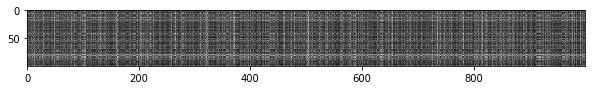

In [12]:
plt.imshow(dists_2, interpolation='none')
plt.show()

In [13]:
y_test_pred = classifier.predict_labels(dists_2, k=1)

In [14]:
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 29 / 100 correct => accuracy: 0.290000


In [15]:
y_test_pred = classifier.predict_labels(dists_2, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 24 / 100 correct => accuracy: 0.240000


**Inline Question 2**

We can also use other distance metrics such as L1 distance.
For pixel values $p_{ij}^{(k)}$ at location $(i,j)$ of some image $I_k$, 

the mean $\mu$ across all pixels over all images is $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
And the pixel-wise mean $\mu_{ij}$ across all images is 
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
The general standard deviation $\sigma$ and pixel-wise standard deviation $\sigma_{ij}$ is defined similarly.

Which of the following preprocessing steps will not change the performance of a Nearest Neighbor classifier that uses L1 distance? Select all that apply.
1. Subtracting the mean $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Subtracting the per pixel mean $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$.
4. Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$.
5. Rotating the coordinate axes of the data.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$


In [16]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loops(x_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists_2 - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [17]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(x_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists_2 - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
  print('Good! The distance matrices are the same')
else:
  print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [18]:
def time_function(f, *args):
    """
    call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic
two_loop_time = time_function(classifier.compute_distances_two_loops, x_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loops, x_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, x_test)
print('No loop version took %f seconds' % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!

# NOTE: depending on what machine you're using, 
# you might not see a speedup when you go from two loops to one loop, 
# and might even see a slow-down.

Two loop version took 2.098094 seconds
One loop version took 1.890830 seconds
No loop version took 0.056871 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [19]:
num_folders = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
x_train_folds = np.array(np.array_split(x_train, num_folders))
y_train_folds = np.array(np.array_split(y_train, num_folders))
k_to_accuracies = {}
for k in k_choices:
    k_to_accuracies[k] = []
    for i in range(num_folders):
        x_train_5 = np.concatenate(x_train_folds[np.where(np.arange(num_folders) != i)[0]], axis=0)
        y_train_5 = np.concatenate(y_train_folds[np.where(np.arange(num_folders) != i)[0]], axis=0)
        x_test_5 = x_train_folds[i]
        y_test_5 = y_train_folds[i]
        classifier.train(x_train_5, y_train_5)
        dists = classifier.compute_distances_no_loops(x_test_5)
        y_test_pred = classifier.predict_labels(dists, k=k)
        num_correct = np.sum(y_test_pred == y_test_5)
        accuracy = float(num_correct) / num_test
        k_to_accuracies[k].append(accuracy)
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))


k = 1, accuracy = 0.470000
k = 1, accuracy = 0.520000
k = 1, accuracy = 0.520000
k = 1, accuracy = 0.480000
k = 1, accuracy = 0.390000
k = 3, accuracy = 0.360000
k = 3, accuracy = 0.430000
k = 3, accuracy = 0.530000
k = 3, accuracy = 0.440000
k = 3, accuracy = 0.430000
k = 5, accuracy = 0.360000
k = 5, accuracy = 0.370000
k = 5, accuracy = 0.500000
k = 5, accuracy = 0.460000
k = 5, accuracy = 0.390000
k = 8, accuracy = 0.370000
k = 8, accuracy = 0.390000
k = 8, accuracy = 0.560000
k = 8, accuracy = 0.470000
k = 8, accuracy = 0.440000
k = 10, accuracy = 0.340000
k = 10, accuracy = 0.380000
k = 10, accuracy = 0.490000
k = 10, accuracy = 0.500000
k = 10, accuracy = 0.420000
k = 12, accuracy = 0.400000
k = 12, accuracy = 0.410000
k = 12, accuracy = 0.520000
k = 12, accuracy = 0.520000
k = 12, accuracy = 0.420000
k = 15, accuracy = 0.380000
k = 15, accuracy = 0.400000
k = 15, accuracy = 0.510000
k = 15, accuracy = 0.510000
k = 15, accuracy = 0.420000
k = 20, accuracy = 0.430000
k = 20, accu

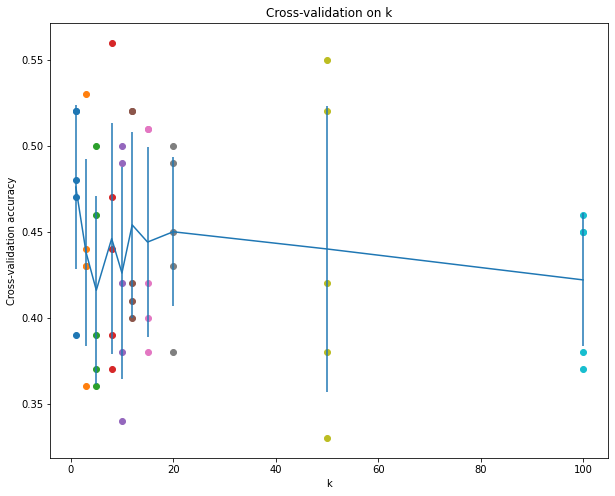

In [20]:
# plot the raw observations
for k in k_choices:
  accuracies = k_to_accuracies[k]
  plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [21]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 50

classifier = KNearetNeighbor()
classifier.train(x_train, y_train)
dists = classifier.compute_distances_no_loops(x_test)
y_test_pred = classifier.predict_labels(dists, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 25 / 100 correct => accuracy: 0.250000
